In [1]:
from imports import *

In [2]:
from datasets.bdd_oia import BDD_OIA
image_dir = './data/bdd_oia/lastframe/data/'
label_dir = './data/bdd_oia/lastframe/labels/'


bdd_oia_dataset = BDD_OIA(image_dir,label_dir+'train_25k_images_actions.json',
                             label_dir+'train_25k_images_reasons.json')

training_loader = DataLoader(bdd_oia_dataset,batch_size=5,num_workers=0,collate_fn=utils.collate_fn)

number of samples in dataset:16028


## Visualization of dataset

In [7]:

with open('./ce 597 demo/readme.txt') as f:
    txt = f.readlines()
all_reasons = np.array([lab.strip()[:-1] for lab in txt[6:-1]])
all_actions = np.array(['move forward', 'stop/slow down', 'turn left', 'turn right'])

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

sample = next(iter(training_loader))


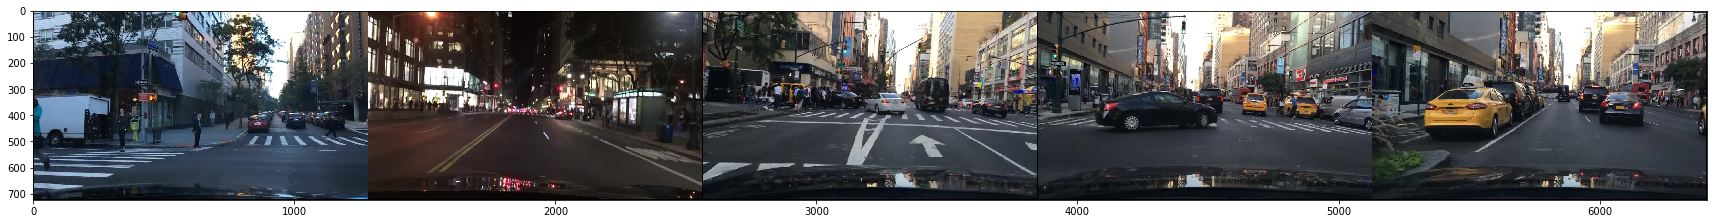

potential actions:  ['stop/slow down', 'turn left']
reasons:  ['s_ob_ped: Stop/slow down - obstacle: person/pedestrain']

potential actions:  ['move forward', 'turn right']
reasons:  ['f_road_clear: Forward - the road is clear', "no_l_solid_line - Can't turn left - solid line on the left"]

potential actions:  ['move forward', 'turn left']
reasons:  ['f_follow_traffic: Forward - follow traffic', 'f_traffic_light: Forward - the traffic light is green', "no_r_car - Can't turn right - obstacles on the right lane"]

potential actions:  ['move forward', 'turn right']
reasons:  ['f_follow_traffic: Forward - follow traffic', "no_l_lane - Can't turn left - no lane on the left"]

potential actions:  ['move forward', 'turn right']
reasons:  ['f_follow_traffic: Forward - follow traffic', "no_l_lane - Can't turn left - no lane on the left"]



In [11]:
# Make a grid from batch
sample = next(iter(training_loader))
images,labels = sample
action_batch = [all_actions[l['action'].numpy()==1] for l in labels]
reason_batch = [all_reasons[r['reason'].numpy()==1] for r in labels]
out = torchvision.utils.make_grid(list(images))

plt.figure(figsize=(30,20))
imshow(out)

for a,b in zip(action_batch,reason_batch):
    print("potential actions: ", list(a))
    print("reasons: ", list(b))
    print()

## Model

In [116]:
device = torch.device("cuda:0")

In [118]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes)
    return model

In [119]:
fastercnn = get_model(10)
checkpoint = torch.load('saved_models/bdd100k_24.pth')
fastercnn.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [121]:
class MHSA(nn.Module):
  def __init__(self,
         emb_dim,
         kqv_dim,
         num_heads=1):
    super(MHSA, self).__init__()
    self.emb_dim = emb_dim
    self.kqv_dim = kqv_dim
    self.num_heads = num_heads

    self.w_k = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_q = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_v = nn.Linear(emb_dim, kqv_dim * num_heads, bias=False)
    self.w_out = nn.Linear(kqv_dim * num_heads, emb_dim)

  def forward(self, x):

    b, t, _ = x.shape
    e = self.kqv_dim
    h = self.num_heads
    keys = self.w_k(x).view(b, t, h, e)
    values = self.w_v(x).view(b, t, h, e)
    queries = self.w_q(x).view(b, t, h, e)

    keys = keys.transpose(2, 1)
    queries = queries.transpose(2, 1)
    values = values.transpose(2, 1)

    dot = queries @ keys.transpose(3, 2)
    dot = dot / np.sqrt(e)
    dot = nn.functional.softmax(dot, dim=3)

    out = dot @ values
    out = out.transpose(1,2).contiguous().view(b, t, h * e)
    out = self.w_out(out)
    return out

In [144]:
class DecisionGenerator(nn.Module):
    def __init__(self,faster_rcnn_model,batch_size=5,action_num=4,explanation_num=21,freeze_rcnn=True):
        super().__init__()

        self.rcnn = faster_rcnn_model
        self.batch_size = batch_size

        if freeze_rcnn:
            for param in self.rcnn.parameters():
                param.requires_grad = False
                self.rcnn.eval()
        self.object_attention = MHSA(1024, kqv_dim=10, num_heads=8)
        self.action_branch = nn.Linear(1024,action_num)

        self.explanation_branch = nn.Linear(1024, explanation_num)
        self.action_loss_fn, self.reason_loss_fn = self.loss_fn()

    def loss_fn(self):
        class_weights = [1, 1, 2, 2]
        w = torch.FloatTensor(class_weights).to(device)
        action_loss = nn.BCEWithLogitsLoss(pos_weight=w).to(device)
        explanation_loss = nn.BCEWithLogitsLoss().to(device)
        return action_loss,explanation_loss


    def forward(self,images,targets):

        target_reasons = torch.stack([t['reason'] for t in targets])
        target_actions = torch.stack([t['action'] for t in targets])

        with torch.no_grad():
            self.rcnn.eval()
            images,_ = self.rcnn.transform(images)
            features = self.rcnn.backbone(images.tensors)
            proposals, _ = self.rcnn.rpn(images, features)

            box_features = self.rcnn.roi_heads.box_roi_pool(features,proposals,images.image_sizes)
            box_features = self.rcnn.roi_heads.box_head(box_features).view(self.batch_size, -1, 1024)  #(B, num_proposal, 1024)
        
        box_features = self.object_attention(box_features) #(B, num_proposal, 1024)
        feature_polled,_ = torch.max(box_features,1)

        actions = self.action_branch(feature_polled)
        reasons = self.explanation_branch(feature_polled)

        action_loss = self.action_loss_fn(actions, target_actions)
        reason_loss = self.reason_loss_fn(reasons, target_reasons)

        loss_dic = {"action_loss":action_loss, "reason_loss":reason_loss}
        return loss_dic


In [145]:
decision_generator = DecisionGenerator(fastercnn)
decision_generator = decision_generator.to(device)
params = [p for p in decision_generator.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-3, max_lr=6e-3)

In [148]:
from engine import train_one_epoch

num_epochs = 1
for epoch in tqdm(range(num_epochs)):
    train_one_epoch(decision_generator, optimizer, training_loader, device, epoch, print_freq=200)
    lr_scheduler.step()

    if epoch == 0:
        save_name = "../saved_models/bdd_oia" + str(epoch) + ".pth"
        torch.save(
            {"model": model.state_dict(), "optimizer": optimizer.state_dict(),},
            save_name,
        )
        print("Saved model", save_name)

  0%|          | 0/1 [00:00<?, ?it/s]Epoch: [0]  [   0/3206]  eta: 0:18:55  lr: 0.000002  loss: 1.5762 (1.5762)  action_loss: 0.8781 (0.8781)  reason_loss: 0.6981 (0.6981)  time: 0.3541  data: 0.0730  max mem: 6174
Epoch: [0]  [ 200/3206]  eta: 0:15:38  lr: 0.000202  loss: 1.4636 (1.4717)  action_loss: 0.7939 (0.7841)  reason_loss: 0.6702 (0.6875)  time: 0.3115  data: 0.0631  max mem: 6174
Epoch: [0]  [ 400/3206]  eta: 0:14:36  lr: 0.000402  loss: 1.2951 (1.4349)  action_loss: 0.7409 (0.7822)  reason_loss: 0.5559 (0.6527)  time: 0.3083  data: 0.0585  max mem: 6174
Epoch: [0]  [ 600/3206]  eta: 0:13:34  lr: 0.000601  loss: 1.1523 (1.3604)  action_loss: 0.7937 (0.7813)  reason_loss: 0.3573 (0.5791)  time: 0.3113  data: 0.0602  max mem: 6174
Epoch: [0]  [ 800/3206]  eta: 0:12:33  lr: 0.000801  loss: 1.0950 (1.2937)  action_loss: 0.7384 (0.7773)  reason_loss: 0.3073 (0.5163)  time: 0.3171  data: 0.0655  max mem: 6174
Epoch: [0]  [1000/3206]  eta: 0:11:33  lr: 0.001000  loss: 1.1005 (1.2550

ValueError: Target size (torch.Size([3, 4])) must be the same as input size (torch.Size([5, 4]))